# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [2]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [3]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [6]:
for i in range(1):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

#### Tensorflow QNetwork

Below is the implementation of an Actor Critic network using tensorflow as the backend model. This contains a tensorflow session and after initially building the network graph, it is trained by running the optimizer with the state, action for accessing the action and q values and the next_state, reward and done for calculating the q_target values for training.

In [7]:
import tensorflow as tf

class TFACNetwork():
    def __init__(self, state_size, action_size, action_range, load=False):
        tf.reset_default_graph()
        self.state_in = tf.placeholder(tf.float32, shape=[None, state_size])
        self.action_in = tf.placeholder(tf.float32, shape=[None, action_size])
        self.next_state_in = tf.placeholder(tf.float32, shape=[None, state_size])
        self.reward_in = tf.placeholder(tf.float32, shape=[None])
        self.done_in = tf.placeholder(tf.float32, shape=[None])

        self.action_low, self.action_high = action_range
        self.actor_local = self.build_actor(action_size, scope="actor_local")
        self.actor_target = self.build_actor(action_size, scope="actor_target")
        self.critic_local = self.build_critic(self.state_in, self.action_in, scope="critic_local")
        self.critic_target = self.build_critic(self.next_state_in, self.actor_target, scope="critic_target")

        self.optimizer = self.build_optimizer()
        self.updater = self.build_updater()
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        self.saver = tf.train.Saver()
        if load: self.load_model()
          
    def build_actor(self, action_size, scope=None):
        with tf.variable_scope(scope):
            layer1 = tf.layers.dense(self.state_in, 100, activation=tf.nn.relu)
            layer2 = tf.layers.dense(layer1, 100, activation=tf.nn.relu)
            layer3 = tf.layers.dense(layer2, 100, activation=tf.nn.relu)
            action_raw = tf.layers.dense(layer3, action_size, activation=None)
            action_scaled = self.action_low + (self.action_high - self.action_low) * tf.nn.sigmoid(action_raw)
            return action_scaled

    def build_critic(self, state, action, scope=None, reuse=False):
        with tf.variable_scope(scope):
            net_state = tf.layers.dense(state, 100, activation=tf.nn.relu, reuse=reuse, name="critic1")
            net_action = tf.layers.dense(action, 100, activation=tf.nn.relu, reuse=reuse, name="critic2")
            net_state_action = tf.concat([net_state, net_action], axis=1)
            net_layer = tf.layers.dense(net_state_action, 100, activation=tf.nn.relu, reuse=reuse, name="critic3")
            q_value = tf.layers.dense(net_layer, 1, activation=None, reuse=reuse, name="critic4")
            return q_value
        
    def build_updater(self, tau=0.01):
        actor_update_ops = [tf.assign(t, t+tau*(l-t)) for l,t in zip(self.get_vars("actor_local"), self.get_vars("actor_target"))]
        critic_update_ops = [tf.assign(t, t+tau*(l-t)) for l,t in zip(self.get_vars("critic_local"), self.get_vars("critic_target"))]
        updater = tf.group(*actor_update_ops, *critic_update_ops)
        return updater
        
    def build_optimizer(self, learn_rate=0.0005, gamma=0.97):
        rewards = tf.expand_dims(self.reward_in, axis=1)
        dones = tf.expand_dims(self.done_in, axis=1)
        q_targets = rewards + gamma * self.critic_target * (1-dones)
        critic_loss = tf.reduce_mean(tf.square(q_targets - self.critic_local))
        critic_optimizer = tf.train.AdamOptimizer(learn_rate).minimize(critic_loss, var_list=self.get_vars("critic_local"))
        
        actor_trainer = self.build_critic(self.state_in, self.actor_local, scope="critic_local", reuse=True)
        actor_advantage = tf.reduce_mean(actor_trainer - self.critic_local)
        actor_optimizer = tf.train.AdamOptimizer(learn_rate).minimize(-actor_advantage, var_list=self.get_vars("actor_local"))
        
        optimizer = tf.group(actor_optimizer, critic_optimizer)
        return optimizer
        
    def get_vars(self, scope):
        return tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope)
    
    def update_model(self, state, action, next_state, reward, done):
        feed = {self.state_in: state, self.action_in: action, self.next_state_in: next_state, self.reward_in: reward, self.done_in: done}
        self.sess.run([self.optimizer, self.updater], feed_dict=feed)
        
    def get_action(self, state):
        action = self.sess.run(self.actor_local, feed_dict={self.state_in: state})
        return action
    
    def save_model(self, path="./checkpoint.ckpt"):
        self.saver.save(self.sess, path)
        
    def load_model(self, path="./checkpoint.ckpt"):
        self.saver.restore(self.sess, path)
    
    def __del__(self):
        self.sess.close()

#### Pytorch QNetwork

Below is the implementation of an Actor Critic network using pytorch as the backend model. This involves first defining a Model class for both the Actor and Critic which subclasses the pytorch nn.Module class and then defines the network graph which can be run with the forward function.

Then the Model is included in an enclosing PTQNetwork class which trains the model by taking in the states and running the Model class to get the q values which are then indexed by the actions and then the gradients are calculated from the MSE loss between the predicted q value and the q_target.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Actor(nn.Module):
    def __init__(self, state_size, action_size, action_range):
        super().__init__()
        self.action_low, self.action_high = action_range
        self.layer1 = nn.Linear(state_size, 100)
        self.layer2 = nn.Linear(100, 100)
        self.layer3 = nn.Linear(100, 100)
        self.action = nn.Linear(100, action_size)

    def forward(self, state):
        layer1 = F.relu(self.layer1(state))
        layer2 = F.relu(self.layer2(layer1))
        layer3 = F.relu(self.layer3(layer1))
        action = F.sigmoid(self.action(layer3))
        return self.action_low + (self.action_high-self.action_low)*action
    
class Critic(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.net_state = nn.Linear(state_size, 100)
        self.net_action = nn.Linear(action_size, 100)
        self.net_layer = nn.Linear(200, 100)
        self.q_value = nn.Linear(100, 1)

    def forward(self, state, action):
        net_state = F.relu(self.net_state(state))
        net_action = F.relu(self.net_action(action))
        net_state_action = torch.cat([net_state, net_action], dim=1)
        net_layer = F.relu(self.net_layer(net_state_action))
        q_value = self.q_value(net_layer)
        return q_value

class PTACNetwork():
    def __init__(self, state_size, action_size, action_range, load=False): 
        self.actor_local = Actor(state_size, action_size, action_range)
        self.actor_target = Actor(state_size, action_size, action_range)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=0.0005)
        
        self.critic_local = Critic(state_size, action_size)
        self.critic_target = Critic(state_size, action_size)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=0.0005)
        if load: self.load_model()
        
    def get_action(self, state):
        state = torch.from_numpy(np.array(state)).float()
        action = self.actor_local(state).detach().numpy()
        return action
    
    def update_model(self, state, action, next_state, reward, done, gamma=0.97):
        states = torch.from_numpy(np.vstack(state)).float()
        actions = torch.from_numpy(np.vstack(action)).float()
        next_states = torch.from_numpy(np.vstack(next_state)).float()
        rewards = torch.from_numpy(np.vstack(reward)).float()
        dones = torch.from_numpy(np.vstack(done)).float()
        next_actions = self.actor_local(next_states)
        
        q_targets = rewards + gamma * self.critic_target(next_states, next_actions).detach() * (1-dones)
        critic_loss = F.mse_loss(self.critic_local(states, actions), q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        q_baseline = self.critic_local(states, actions).detach()
        actor_gain = -(self.critic_local(states, self.actor_local(states)) - q_baseline)
        self.actor_optimizer.zero_grad()
        actor_gain.mean().backward()
        self.actor_optimizer.step()
        
        self.soft_copy(self.actor_local, self.actor_target)
        self.soft_copy(self.critic_local, self.critic_target)
        
    def soft_copy(self, local, target, tau=0.01):
        for t,l in zip(target.parameters(), local.parameters()):
            t.data.copy_(t.data + tau*(l.data - t.data))
        
    def save_model(self, path="checkpoint.pth"):
        torch.save(self.actor_local.state_dict(), "a_local_{}".format(path))
        torch.save(self.actor_target.state_dict(), "a_target_{}".format(path))
        torch.save(self.critic_local.state_dict(), "c_local_{}".format(path))
        torch.save(self.critic_target.state_dict(), "c_target_{}".format(path))
        
    def load_model(self, path="checkpoint.pth"):
        self.actor_local.load_state_dict(torch.load("a_local_{}".format(path)))
        self.actor_target.load_state_dict(torch.load("a_target_{}".format(path)))
        self.critic_local.load_state_dict(torch.load("c_local_{}".format(path)))       
        self.critic_target.load_state_dict(torch.load("c_target_{}".format(path)))

#### Experience Replay

Below is the implementation of a Replay Buffer using the deque collection as the rolling buffer of experience tuples. This can be sampled by specifying the sample size and then returns each individual experience type as separate lists.

In [9]:
from collections import deque
import random

class ReplayBuffer():
    def __init__(self, maxlen):
        self.buffer = deque(maxlen=maxlen)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        sample_size = min(len(self.buffer), batch_size)
        samples = random.choices(self.buffer, k=sample_size)
        return map(list, zip(*samples))

#### Exploration Noise

Below is the noise process class for exploration of continuous action spaces where noise applied to the action vector varies randomly with inertia from the previous time step.

In [10]:
class OUNoise():
    def __init__(self, size, scale, mu=0.0, sigma=0.4, theta=0.15, decay=0.995):
        self.noise = np.zeros(size)
        self.size = size
        self.scale = scale
        self.mu = mu
        self.sigma = sigma
        self.theta = theta
        self.decay = decay
    
    def reset(self):
        self.noise = np.zeros(self.size)
        self.scale *= self.decay
        
    def sample(self):
        sample = self.theta * (self.mu - self.noise) + self.sigma * np.random.randn(self.size)
        self.noise = sample * self.scale
        return self.noise

#### Agent

Below is the implementation of the agent that uses Deep Actor Critic networks to learn the best action for a given state such that it achieves a reward is better than the critic's estimated value of it. It selects an action from the actor model which then explores by adding a noise process to it which decays over time.

In [11]:
class ActorCriticAgent():
    # Initializing the agent and the model for selecting actions
    def __init__(self, state_size, action_size, action_range=[-1,1], load=False):
        # The number of state values in the state vector
        self.state_size = state_size
        # The number of action indices to select from
        self.action_size = action_size
        # Defining the q network to use for modeling the Bellman equation
        self.q_network = PTACNetwork(state_size, action_size, action_range, load)
        # Defining the replay buffer for experience replay
        self.replay_buffer = ReplayBuffer(100000)
        # Initializing the epsilon value to 1.0 for initial exploration
        self.noise_process = OUNoise(action_size, action_range[1]-action_range[0])
        
    # Function for getting an action to take in the given state
    def get_action(self, state):
        # Get the action from the network and add noise to it
        return self.q_network.get_action([state])[0] + self.noise_process.sample()
        
    # Function for training the agent at each time step
    def train(self, state, action, next_state, reward, done, batch_size=100):
        # First add the experience to the replay buffer
        self.replay_buffer.add((state, action, next_state, reward, done))
        # Sample a batch of each experience type from the replay buffer
        states, actions, next_states, rewards, dones = self.replay_buffer.sample(batch_size)
        # Train the model with the q target
        self.q_network.update_model(states, actions, next_states, rewards, dones)
        # Decrease epsilon after each episode
        if done: self.noise_process.reset()

#### Multi-Agent Group

Below is the implementation of the agent that contains a number of actor-critic agents for playing in a multi-agent environment. It takes in the list of states, actions, next_states, rewards and dones for each agent and outputs a joint action.

In [12]:
class MAACAgent():
    # Initializing the agent with a specified number of single agents
    def __init__(self, num_agents, state_size, action_size, load=False):
        # Creating the list of agents
        self.agents = [ActorCriticAgent(state_size, action_size) for _ in range(num_agents)]
        # Loading weights if specified
        if load: self.load()
        
    # Function for getting the list of actions to take in each agent's local state
    def get_action(self, states):
        # Get an action from each agent
        actions = [agent.get_action(state) for agent,state in zip(self.agents, states)]
        return actions
        
    # Function for training each agent with their local experience
    def train(self, states, actions, next_states, rewards, dones, batch_size=100):
        # Loop through each agent and their corresponding experience tuple
        for agent,s,a,ns,r,d in zip(self.agents,states,actions,next_states,rewards,dones):
            # Call its independent train function
            agent.train(s, a, ns, r, d, batch_size)
            
    # Function for saving the weights of each agent
    def save(self):
        for i,agent in enumerate(self.agents):
            agent.q_network.save_model(path="ma{}.pth".format(i))
            
    # Function for loading the weights to each agent
    def load(self):
        for i,agent in enumerate(self.agents):
            agent.q_network.load_model(path="ma{}.pth".format(i))

#### Training

Below is the training loop for training the agent through a number of episodes of interacting with the environment. It keeps track of the total reward from each episode and also stores the last 100 episode rewards for calculating the average reward for checking when the environment was solved.

In [13]:
# Create an agent instance
agent = MAACAgent(num_agents, state_size, action_size)
# Define number of episodes to train for
num_episodes = 1500
# Create a buffer for calculating the last 100 episode average reward
scores_buffer = deque(maxlen=100)
# List to store each episode's total reward
scores = []
# List to store the average reward after each episode
avg_scores = []

# Run the training loop
for ep in range(num_episodes):
    # Reset the environment to get the initial state
    env_info = env.reset(train_mode=False)[brain_name]
    # Save the initial state
    states = env_info.vector_observations
    # Reset the total reward
    total_rewards = np.zeros(num_agents)
    # Reset the episode terminal condition
    dones = [False] * num_agents
    while not np.any(dones):
        # Query the agent for an action to take in the state
        actions = agent.get_action(states)
        # Take the action in the environment
        env_info = env.step(actions)[brain_name] 
        # Save the next state
        next_states = env_info.vector_observations
        # Save the reward
        rewards = env_info.rewards    
        # Save the terminal condition update
        dones = [int(done) for done in env_info.local_done]
        # Train the agent with the new time step experience
        agent.train(states, actions, next_states, rewards, dones)
        # Update the episode's total reward
        total_rewards += rewards             
        # Update the current state
        states = next_states 
        
    # Store the last episode's total reward
    scores.append(np.mean(total_rewards))
    # Add the total reward to the buffer for calculating average reward
    scores_buffer.append(np.mean(total_rewards))
    # Store the new average reward
    avg_scores.append(np.mean(scores_buffer))
    print("Episode: {}, Score: {:.5f}, Avg reward: {:.2f}".format(ep, scores[ep], avg_scores[ep]))

agent.save()

Episode: 0, Score: -0.00500, Avg reward: -0.00
Episode: 1, Score: -0.00500, Avg reward: -0.00
Episode: 2, Score: -0.00500, Avg reward: -0.00
Episode: 3, Score: -0.00500, Avg reward: -0.00
Episode: 4, Score: -0.00500, Avg reward: -0.00
Episode: 5, Score: -0.00500, Avg reward: -0.00
Episode: 6, Score: -0.00500, Avg reward: -0.00
Episode: 7, Score: -0.00500, Avg reward: -0.00
Episode: 8, Score: -0.00500, Avg reward: -0.00
Episode: 9, Score: -0.00500, Avg reward: -0.00
Episode: 10, Score: -0.00500, Avg reward: -0.00
Episode: 11, Score: -0.00500, Avg reward: -0.00
Episode: 12, Score: -0.00500, Avg reward: -0.00
Episode: 13, Score: -0.00500, Avg reward: -0.00
Episode: 14, Score: -0.00500, Avg reward: -0.00
Episode: 15, Score: -0.00500, Avg reward: -0.00
Episode: 16, Score: -0.00500, Avg reward: -0.00
Episode: 17, Score: -0.00500, Avg reward: -0.00
Episode: 18, Score: -0.00500, Avg reward: -0.00
Episode: 19, Score: -0.00500, Avg reward: -0.00
Episode: 20, Score: -0.00500, Avg reward: -0.00
Ep

#### Plotting the training rewards

The plot below shows the total reward from each episode (blue) and the average reward over the last 100 episodes (orange). We can see that the agent was able to reach the average reward of 30 after about 200 episodes.

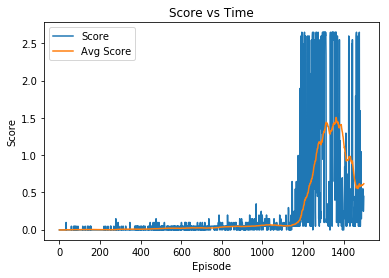

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

x = range(len(scores))
plt.plot(x, scores, label="Score")
plt.plot(x, avg_scores, label="Avg Score")
plt.title("Score vs Time")
plt.xlabel("Episode")
plt.ylabel("Score")
plt.legend()

#### Evaluation

The cell below creates a test agent loading the trained weights for a test run of the environment with the trained model. Change the num_episodes variable to run the simulation and calculate the average reward total over multiple episodes.

In [34]:
test_agent = MAACAgent(num_agents, state_size, action_size, load=True)
num_episodes = 1

for ep in range(num_episodes):
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations
    total_rewards = np.zeros(num_agents)
    dones = [False] * num_agents
    while not np.any(dones):
        actions = test_agent.get_action(states)
        env_info = env.step(actions)[brain_name] 
        next_states = env_info.vector_observations
        rewards = env_info.rewards    
        dones = [int(done) for done in env_info.local_done]
        total_rewards += rewards             
        states = next_states 

    print("Episode: {}, Score: {:.5f}".format(ep, np.mean(total_rewards)))

Episode: 0, Score: 0.34500


When finished, you can close the environment.

In [ ]:
env.close()